# Using Clustering and web scarping to Identify Optimum Location(S) for a Supermarket in SF

## 1.Importing the Necessary Libraries 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


In [2]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francisco, United States'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

## 2. Getting the data/Web scraping

In [3]:
data = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco").text
soup = BeautifulSoup(data, 'html.parser')
neighborhoodList = []
# append the data into the list
for i in soup.find("div", {"id":"toc"}).find_all("span",{"class":"toctext"}):
    neighborhoodList.append(i.get_text())
     

In [4]:
df = pd.DataFrame(neighborhoodList)
df.columns = ['neighborhood']
df.head()
coords = [ get_latlng(neighborhood) for neighborhood in df["neighborhood"].tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df.head()

Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)


,neighborhood,Latitude,Longitude
0,Alamo Square,37.77722,-122.43146
1,Anza Vista,37.78048,-122.44358
2,Ashbury Heights,37.76467,-122.44587
3,Balboa Park,37.72493,-122.44314
4,Balboa Terrace,37.73180,-122.46740


In [5]:
# get the coordinates of Kuala Lumpur
address = 'San Francisco, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 37.7790262, -122.4199061.


## Visualizing all the neighborhoods in San Francisco 

In [6]:
# create map of New York using latitude and longitude values
map_sf = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

## 3. Using Foursquare to get the venues in each neighborhood upto a distance of 2000 M 

In [3]:
CLIENT_ID = 'ANxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ANxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxx


In [8]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


In [9]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(11758, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Alamo Square,37.77722,-122.43146,Alamo Square,37.776045,-122.434363,Park
1,Alamo Square,37.77722,-122.43146,Painted Ladies,37.776120,-122.433389,Historic Site
2,Alamo Square,37.77722,-122.43146,The Center SF,37.774545,-122.430730,Spiritual Center
3,Alamo Square,37.77722,-122.43146,Alamo Square Dog Park,37.775878,-122.435740,Dog Run
4,Alamo Square,37.77722,-122.43146,Salt & Straw,37.776532,-122.426051,Ice Cream Shop


## Understanding diffrent types of venues  

In [10]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))


There are 323 uniques categories.


In [11]:
venues_df['VenueCategory'].unique()[:50]

array(['Park', 'Historic Site', 'Spiritual Center', 'Dog Run',
       'Ice Cream Shop', 'Liquor Store', 'German Restaurant',
       'Sushi Restaurant', 'Rock Club', 'Yoga Studio', 'Souvlaki Shop',
       'Market', 'Pizza Place', 'Bakery', 'Bar', 'Gift Shop',
       'Coffee Shop', 'New American Restaurant', 'Wine Bar',
       'Seafood Restaurant', 'BBQ Joint', 'Bagel Shop', 'Event Space',
       'Pedestrian Plaza', 'Cocktail Bar',
       'Southern / Soul Food Restaurant', 'Bike Shop', 'Comic Shop',
       'Italian Restaurant', 'Butcher', 'American Restaurant',
       'Music Venue', 'Gastropub', 'Bubble Tea Shop', 'French Restaurant',
       'Furniture / Home Store', 'Restaurant', 'Spa',
       'Vietnamese Restaurant', 'Jazz Club', 'Bookstore',
       'Mexican Restaurant', 'Burrito Place', 'Grocery Store',
       'Optical Shop', 'Bath House', 'Opera House', 'Dance Studio',
       'Concert Hall', 'Plaza'], dtype=object)

In [12]:
venue_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")


In [13]:
venue_onehot.head()

,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Storage Facility,Street Art,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Resta

In [14]:
test1 = venues_df['VenueCategory'].head(5)
test1

0                Park
1       Historic Site
2    Spiritual Center
3             Dog Run
4      Ice Cream Shop
Name: VenueCategory, dtype: object

In [15]:
test2 = pd.get_dummies(test1, prefix="", prefix_sep="")

In [16]:
test2

,Dog Run,Historic Site,Ice Cream Shop,Park,Spiritual Center
0,0,0,0,1,0
1,0,1,0,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,1,0,0


## creating a one hot encoding Dataframe,which we will further use to calculate Mean of each venue, gruped by its Neighborhood

In [17]:
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head()

(11758, 324)


,Neighborhoods,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Storage Facility,Street Art,Street Food Gathering,Supermarket,Supplement Shop,Surf Sp

In [19]:
sf_grouped = onehot.groupby(["Neighborhoods"]).mean().reset_index()

sf_grouped.head()


,Neighborhoods,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Storage Facility,Street Art,Street Food Gathering,Supermarket,Supplement Shop,Surf Sp

In [21]:
# supermarket 
sf_supermaktet = sf_grouped[['Neighborhoods','Supermarket','Bus Station']]
sf_supermaktet.head(20)

,Neighborhoods,Supermarket,Bus Station
0,Alamo Square,0.00,0.0
1,Anza Vista,0.01,0.0
2,Ashbury Heights,0.01,0.0
3,Balboa Park,0.00,0.0
4,Balboa Terrace,0.00,0.0
5,Bayview,0.00,0.0
6,Belden Place,0.00,0.0
7,Bernal Heights,0.00,0.0
8,Buena Vista,0.01,0.0
9,Butchertown (Old and New),0.00,0.0


##  4. Clustering Using Kmeans 

In [22]:
# clustering 
# set number of clusters
kclusters = 3

sf_clustering = sf_supermaktet.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_clustering)


/Users/shreyakvashisht/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/shreyakvashisht/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/shreyakvashisht/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/shreyakvashisht/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


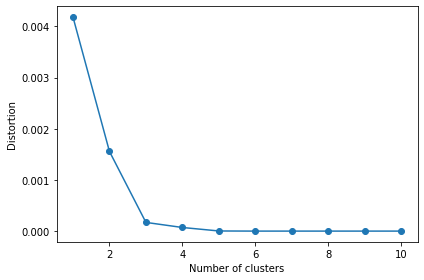

In [24]:
# opitmize the numbeers of cluters 
import matplotlib.pyplot as plt

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(sf_clustering)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [25]:
sf_sup_merged  = sf_supermaktet.copy()
sf_sup_merged["Cluster Labels"] = kmeans.labels_

## Considering Supermarkets with Proximity to Bus Station 

In [26]:
sf_sup_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
sf_sup_merged.head()

,Neighborhood,Supermarket,Bus Station,Cluster Labels
0,Alamo Square,0.00,0.0,0
1,Anza Vista,0.01,0.0,2
2,Ashbury Heights,0.01,0.0,2
3,Balboa Park,0.00,0.0,0
4,Balboa Terrace,0.00,0.0,0


In [31]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sf_sup_merged = sf_sup_merged.join(df.set_index("neighborhood"), on="Neighborhood")

print(sf_sup_merged.shape)
sf_sup_merged.head() # check the last columns!

(123, 6)


,Neighborhood,Supermarket,Bus Station,Cluster Labels,Latitude,Longitude
0,Alamo Square,0.00,0.0,0,37.77722,-122.43146
1,Anza Vista,0.01,0.0,2,37.78048,-122.44358
2,Ashbury Heights,0.01,0.0,2,37.76467,-122.44587
3,Balboa Park,0.00,0.0,0,37.72493,-122.44314
4,Balboa Terrace,0.00,0.0,0,37.73180,-122.46740


## 5.Visualizing and Analysing each Cluster 

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_sup_merged['Latitude'], sf_sup_merged['Longitude'], sf_sup_merged['Neighborhood'], sf_sup_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
sf_sup_merged.loc[sf_sup_merged['Cluster Labels'] == 0]


,Neighborhood,Supermarket,Bus Station,Cluster Labels,Latitude,Longitude
0,Alamo Square,0.0,0.00,0,37.777220,-122.431460
3,Balboa Park,0.0,0.00,0,37.724930,-122.443140
4,Balboa Terrace,0.0,0.00,0,37.731800,-122.467400
5,Bayview,0.0,0.00,0,37.733450,-122.389980
6,Belden Place,0.0,0.00,0,37.791275,-122.403785
7,Bernal Heights,0.0,0.00,0,37.739030,-122.416210
9,Butchertown (Old and New),0.0,0.00,0,37.777120,-122.419640
10,Castro,0.0,0.00,0,37.758490,-122.434770
11,Cathedral Hill,0.0,0.00,0,37.792000,-122.413380
12,Cayuga Terrace,0.0,0.00,0,37.723062,-122.439146


In [34]:
sf_sup_merged.loc[sf_sup_merged['Cluster Labels'] == 1]



,Neighborhood,Supermarket,Bus Station,Cluster Labels,Latitude,Longitude
56,Little Hollywood,0.0,0.023256,1,37.709930,-122.398300
106,Sunnydale,0.0,0.032258,1,37.712251,-122.417304
122,Yerba Buena,0.0,0.034483,1,37.810329,-122.366900


In [35]:
sf_sup_merged.loc[sf_sup_merged['Cluster Labels'] == 2]



,Neighborhood,Supermarket,Bus Station,Cluster Labels,Latitude,Longitude
1,Anza Vista,0.01,0.0,2,37.780480,-122.443580
2,Ashbury Heights,0.01,0.0,2,37.764670,-122.445870
8,Buena Vista,0.01,0.0,2,37.767162,-122.438187
16,Clarendon Heights,0.01,0.0,2,37.758990,-122.448770
17,Cole Valley,0.01,0.0,2,37.765320,-122.449870
18,Corona Heights,0.01,0.0,2,37.763640,-122.440390
38,Haight-Ashbury,0.01,0.0,2,37.769930,-122.446920
49,Jordan Park,0.01,0.0,2,37.784650,-122.456640
51,Lake Street,0.01,0.0,2,37.785060,-122.464040
59,Lone Mountain,0.01,0.0,2,37.777910,-122.452620


## Conclusion + Insights 

The whole idea behind this Project is to find the top Location(s) for a Supermarket<br>
we Tried to Cluster neighborhoods based on the occurance of Supermarket and proximity to Bus station<br>
Cluster1,did not have any Supermarket nor had any Bus stations,so ideally not our top Choice but can still be considered because competition will be less<br>
Cluster2,is our **top choice** becasue it had comparitively more Bus Station and no Supermarkets which means opening a supermarket here, will face no competition and easy access to Transportation resulting in higher Foot fall<br>
Cluster3,is not our choice becasue of the prescence of other Supermarkets ie higher competition
The top locality are: <br>
<br>
1.Little Hollywood<br>
2. Sunnydale<br>
3. Yerba Buena<br>
